In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('diabetic_data.csv')

### Cleaning dataset to make patient IDs and encounter IDs unique

All encounter numbers in the dataset are unique, but the patient numbers are not unique. Some patients are represented many times.

In [108]:
df.patient_nbr.value_counts()

88785891     40
43140906     28
23199021     23
1660293      23
88227540     23
             ..
71081460      1
30060018      1
67443444      1
141344240     1
93251151      1
Name: patient_nbr, Length: 71518, dtype: int64

Logically, you might think that patients with multiple encounters would mean that the patients were readmitted, and vice versa, that patients with a single encounter would mean that they are not readmitted. However, this is not the case, therefore the researchers are coding the readmitted column based on information that may not be available to us.

In [2]:
patient_nbr_counts = df.patient_nbr.value_counts()
single_patient_nbrs=patient_nbr_counts[patient_nbr_counts==1].index
multiple_patient_nbrs=patient_nbr_counts[patient_nbr_counts!=1].index

print("Unique patient numbers, and their readmitted status:")
print(df.loc[df.patient_nbr.isin(single_patient_nbrs)].readmitted.value_counts())
print()
print("Non-unique patient numbers, and their readmitted status:")
print(df.loc[df.patient_nbr.isin(multiple_patient_nbrs)].readmitted.value_counts())

Unique patient numbers, and their readmitted status:
NO     42701
>30     9878
<30     2166
Name: readmitted, dtype: int64

Non-unique patient numbers, and their readmitted status:
>30    25667
NO     12163
<30     9191
Name: readmitted, dtype: int64


**Example of patients with multiple encounters, showing that demographic information doesn't change but the patient gets older.**

In [110]:
df.loc[df.patient_nbr==5220].sort_values('encounter_id')

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1083,7981038,5220,Caucasian,Male,[60-70),?,1,1,7,2,...,No,Steady,No,No,No,No,No,No,Yes,>30
6901,33503946,5220,Caucasian,Male,[70-80),?,2,1,1,11,...,No,Steady,No,No,No,No,No,No,Yes,>30
14128,55397514,5220,Caucasian,Male,[70-80),?,2,6,1,8,...,No,Steady,No,No,No,No,No,No,Yes,>30
16105,60892254,5220,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Steady,No,No,No,No,No,No,Yes,NO


In [111]:
df.loc[df.patient_nbr==1152].sort_values('encounter_id')

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1164,8380170,1152,AfricanAmerican,Female,[50-60),?,1,1,7,6,...,No,Steady,No,No,No,No,No,No,Yes,>30
5953,30180318,1152,AfricanAmerican,Female,[50-60),?,1,1,7,6,...,No,Down,No,No,No,No,No,Ch,Yes,>30
14180,55533660,1152,AfricanAmerican,Female,[60-70),?,1,1,7,10,...,No,Steady,No,No,No,No,No,No,Yes,>30
23623,80742510,1152,AfricanAmerican,Female,[60-70),?,1,1,7,8,...,No,Steady,No,No,No,No,No,No,Yes,>30
24642,83281464,1152,AfricanAmerican,Female,[60-70),?,1,1,7,12,...,No,Up,No,No,No,No,No,Ch,Yes,NO


In [3]:
multiple_encounters_cleaned = df.loc[df.patient_nbr.isin(multiple_patient_nbrs)]\
                            .groupby('patient_nbr').encounter_id.min()
single_encounters_cleaned = df.loc[df.patient_nbr.isin(single_patient_nbrs)].encounter_id
merged_encounters_cleaned = pd.concat([single_encounters_cleaned,multiple_encounters_cleaned])
df = df.loc[df.encounter_id.isin(merged_encounters_cleaned)]

### Identifying important features

In [50]:
rehosp = df.loc[df.readmitted=='<30']
norehosp = df.loc[df.readmitted=='NO']
laterehosp = df.loc[df.readmitted=='>30']

In [51]:
def plot_rehosp_vs_total(column,sort=True):
    test = pd.DataFrame(df[column].value_counts(normalize=True))
    test2 = rehosp[column].value_counts(normalize=True)
    result = pd.concat([test,test2],axis=1)
    result.columns = ['total','rehosp']
    result['diff'] = result.rehosp - result.total
    if sort:
        result['diff'].sort_values().plot.barh()
    else:
        result['diff'].plot.barh()
    plt.title('Differences by '+column)
    plt.show()
    
def plot_rehosp_vs_not(column,sort=True):
    test = pd.DataFrame(norehosp[column].value_counts(normalize=True))
    test2 = rehosp[column].value_counts(normalize=True)
    result = pd.concat([test,test2],axis=1)
    result.columns = ['norehosp','rehosp']
    result['diff'] = result.rehosp - result.norehosp
    if sort:
        result['diff'].sort_values().plot.barh()
    else:
        result['diff'].plot.barh()
    plt.title('Differences by '+column)
    plt.show()
    
def plot_rehosp_vs_laterehosp(column,sort=True):
    test = pd.DataFrame(laterehosp[column].value_counts(normalize=True))
    test2 = rehosp[column].value_counts(normalize=True)
    result = pd.concat([test,test2],axis=1)
    result.columns = ['laterehosp','rehosp']
    result['diff'] = result.rehosp - result.laterehosp
    if sort:
        result['diff'].sort_values().plot.barh()
    else:
        result['diff'].plot.barh()
    plt.title('Differences by '+column)
    plt.show()

In [52]:
columns_to_check_sortedoutput = ['race', 'gender', 'age','admission_type_id', 
                    'discharge_disposition_id', 'admission_source_id', 'payer_code',
                   'max_glu_serum','A1Cresult']

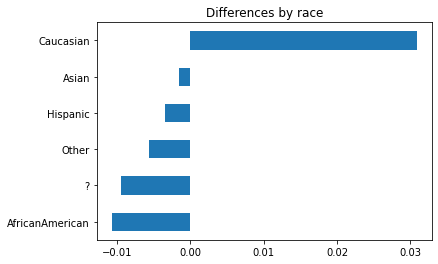

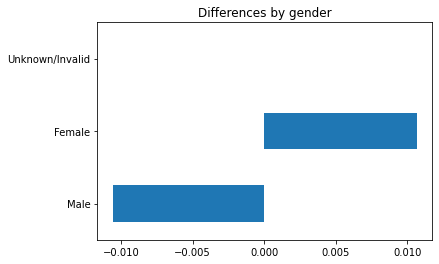

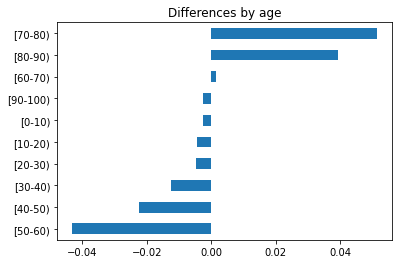

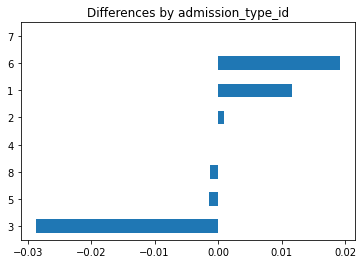

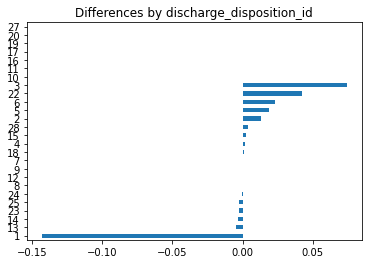

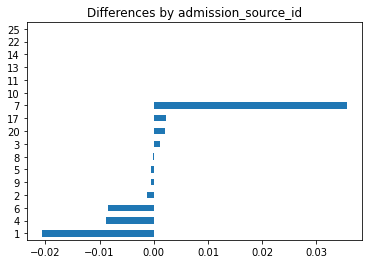

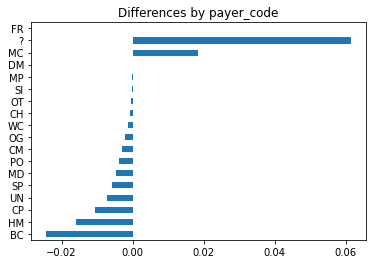

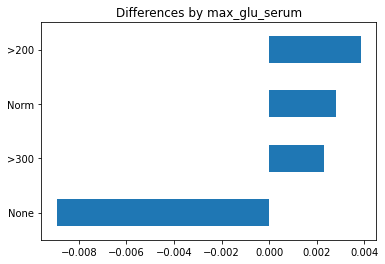

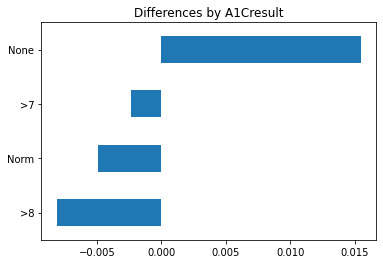

In [53]:
for i in columns_to_check_sortedoutput:
    plot_rehosp_vs_not(i)

**Race had a weak effect:** For example, Caucasians were 3% more likely to be rehospitalized vs. not, and African Americans 1% less likely.

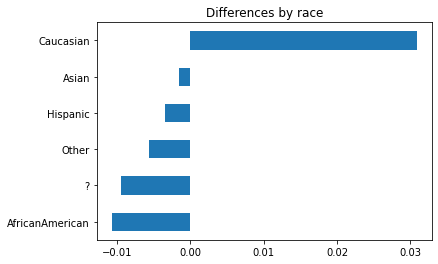

In [95]:
plot_rehosp_vs_not('race')

**Age also has a weak effect:** Older patients were more likely to be rehospitalized.

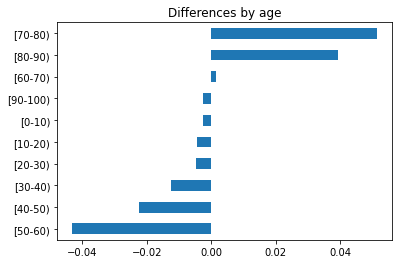

In [97]:
plot_rehosp_vs_not('age')

**Admission type had an effect:** 3 indicates elective admission, 6 indicates NULL, 1 indicates Emergency

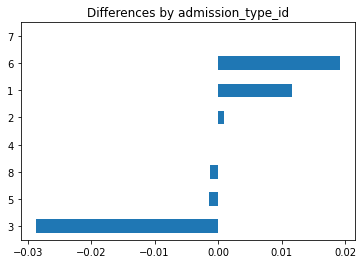

In [98]:
plot_rehosp_vs_not('admission_type_id')

**Discharge disposition id had a strong effect:**
1 indicates discharged to home; 3 indicates discharged to SNF

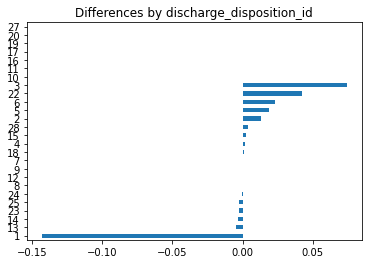

In [96]:
plot_rehosp_vs_not('discharge_disposition_id')

**Number of inpatient visits in the previous year had a strong effect as well:**

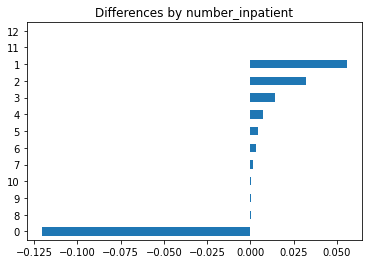

In [100]:
plot_rehosp_vs_not('number_inpatient')

**Having a look at numeric ordinal values**

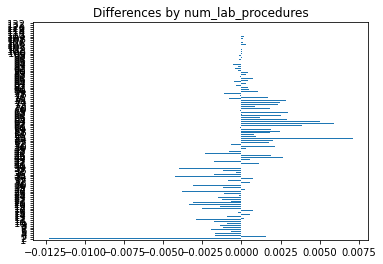

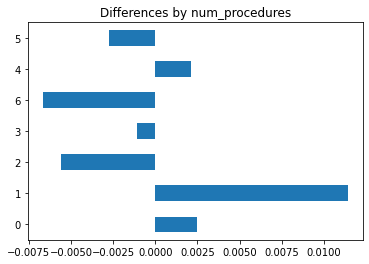

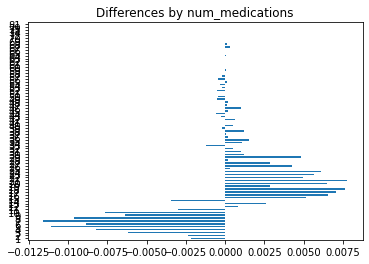

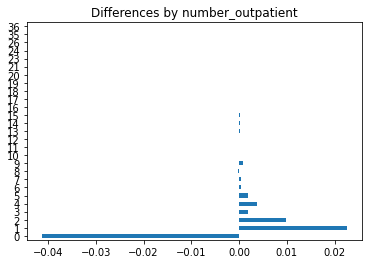

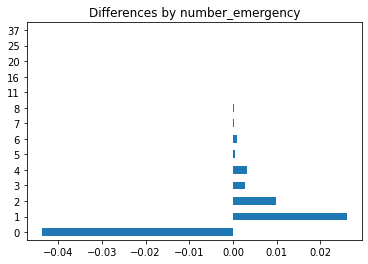

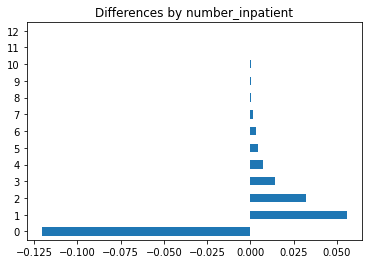

In [102]:
columns_to_check_numeric = ['num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient']
for i in columns_to_check_numeric:
    plot_rehosp_vs_not(i,sort=False)

In [104]:
df.payer_code.value_counts()

?     40256
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: payer_code, dtype: int64